# plotly........w

In [6]:
import datetime
from math import floor
import pprint
import schedule
from statistics import mean
from statistics import median
from statistics import StatisticsError
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.accounts as accounts
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.pricing as pricing
from oandapyV20.endpoints.pricing import PricingInfo
from oandapyV20.contrib.requests import (MarketOrderRequest, StopLossDetails)
import oandapyV20.endpoints.forexlabs as labs
from plotly.offline import init_notebook_mode, iplot
from plotly import figure_factory as FF
init_notebook_mode(connected=True) # Jupyter notebook用設定

sys.path.append('../')
from oandapyV21 import *

# OANDA API v20の口座IDとAPIトークン(ドル円) py703413
accountID = "101-009-12609641-001"
access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"

## BT

In [19]:
# バックテスト
def back_test(df, fee, seed_money, n=10, lot=1000, kly_rate='None', print_=True):
    pos = 'None'
    assets = seed_money
    tmp_i = 0
    lot_l = []
    l_or_s = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []

    # 実行
    for i in range(n, len(df)-1):
        next_rate = df.iat[i+1, 2] # シグナル点灯した次の足の始値
        high_l = []
        low_l = []
        for j in range(n):
            high_l.extend([df.iat[i-j-1, 3]])
            low_l.extend([df.iat[i-j-1, 4]])
        highest = max(high_l)
        lowest = min(low_l)
    
        # 上昇トレンドと判断しロング
        if df.iat[i, 5] > highest:
            if pos == 'entry_long':
                continue
            else:
                # もし逆のポジションを持ってたら利確
                if pos == 'entry_short':
                    exit_rate = next_rate
                    pips = (entry_rate - exit_rate - fee) * 100
                    if kly_rate != 'None':
                        kly = assets * kly_rate
                        lot = floor(kly / exit_rate)
                    profit = pips * lot / 100
                    assets = round(assets + profit, 4)
                    lot_l.extend([lot])
                    l_or_s.extend(['short'])
                    entry_date.extend([df.iat[tmp_i, 0]])
                    entry_rate_l.extend([entry_rate])
                    exit_date.extend([df.iat[i, 0]])
                    exit_rate_l.extend([exit_rate])
                    pips_l.extend([pips])
                    profit_l.extend([profit])
                    assets_l.extend([assets])
                    if assets < 0:
                        break
                entry_rate = next_rate
                pos = 'entry_long'
                tmp_i = i
        
        # 下降トレンドと判断しショート
        if df.iat[i, 5] > lowest:
            if pos == 'entry_short':
                continue
            else:
                # もし逆のポジションを持ってたら利確
                if pos == 'entry_long':
                    exit_rate = next_rate
                    pips = (exit_rate - entry_rate - fee) * 100
                    if kly_rate != 'None':
                        kly = assets * kly_rate
                        lot = floor(kly / exit_rate)
                    profit = pips * lot / 100
                    assets = round(assets + profit, 4)
                    lot_l.extend([lot])
                    l_or_s.extend(['long'])
                    entry_date.extend([df.iat[tmp_i, 0]])
                    entry_rate_l.extend([entry_rate])
                    exit_date.extend([df.iat[i, 0]])
                    exit_rate_l.extend([exit_rate])
                    pips_l.extend([pips])
                    profit_l.extend([profit])
                    assets_l.extend([assets])
                    if assets < 0:
                        break
                entry_rate = next_rate
                pos = 'entry_short'
                tmp_i = i
    
    pos_df = pd.DataFrame(data={'lot': lot_l, 'l_or_s': l_or_s, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df

In [13]:
df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', 'H12', 'USD_JPY')

In [21]:
fig = FF.create_candlestick(df['Open'], df['High'], df['Low'], df['Close'])

xtick0 = (5-df.iat[0, 0].weekday())%5 #最初の月曜日のインデックス
fig['layout'].update({
    'xaxis':{
        'showgrid': True,
        'ticktext': [x.strftime('%Y-%m-%d') for x in df['Time']][xtick0::5],
        'tickvals': np.arange(xtick0,len(df),5)
    }
})

iplot(fig)

In [23]:
df.tail(15)

,Time,Volume,Open,High,Low,Close
5554,2019-12-19 10:00:00+00:00,3981,109.558,109.560,109.184,109.359
5555,2019-12-19 22:00:00+00:00,2901,109.370,109.405,109.255,109.333
5556,2019-12-20 10:00:00+00:00,3322,109.336,109.526,109.285,109.443
5557,2019-12-22 22:00:00+00:00,2719,109.460,109.538,109.346,109.376
5558,2019-12-23 10:00:00+00:00,2448,109.378,109.447,109.340,109.392
5559,2019-12-23 22:00:00+00:00,2676,109.396,109.440,109.363,109.410
5560,2019-12-24 10:00:00+00:00,3848,109.407,109.420,109.328,109.398
5561,2019-12-25 22:00:00+00:00,2412,109.398,109.572,109.346,109.550
5562,2019-12-26 10:00:00+00:00,1921,109.552,109.684,109.539,109.639
5563,2019-12-26 22:00:00+00:00,9090,109.597,109.602,109.434,109.483


In [4]:
df.head()

,Time,Volume,Open,High,Low,Close
0,2009-12-31 22:00:00+00:00,3,93.069,93.069,93.047,93.047
1,2010-01-03 10:00:00+00:00,409,92.943,93.054,92.925,92.986
2,2010-01-03 22:00:00+00:00,14050,92.984,93.213,92.696,92.802
3,2010-01-04 10:00:00+00:00,13536,92.800,92.943,92.186,92.509
4,2010-01-04 22:00:00+00:00,13941,92.506,92.555,91.638,91.880


### 通貨ペアと足と参照本数の検証

In [22]:
# スプレッド取得
sp = {}
for inst in all_inst():
    sp[inst] = pip_spread(inst)[2]

In [23]:
# スプレッド出力
pd.DataFrame(data=sp.items(), columns=['instrument', 'spread']).to_csv('spreads.csv', index=False)
# sp = pd.read_csv('spreads.csv').to_dict()

In [ ]:
# 足検証
inst_df = pd.DataFrame(columns=['instrument', 'gran', 'n', 'pos_count', 'profit',
                                'WP(%)', 'POR', 'PF', 'E(円)', 'DD(%)', 'KLY(%)'])
grans = ['M30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12', 'D']
grans.reverse()
for inst in all_inst()[18:]:
    print('{} start'.format(inst))
    for gran in grans:
        df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', gran, inst)
        for n in range(5, 55, 5):
#             print('inst: {}, gran: {:>3}, n: {:>2}, '.format(inst, gran, n), end='')
            pos_df = back_test(df, fee=sp[inst], seed_money=1000000, n=n, print_=False)
            pos_count, profit = pos_df.shape[0], pos_df['pips'].sum() / 100
            WP, POR, PF, E, DD, KLY = get_evaluation(pos_df, return_=True)
#             print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, profit))
            tmp_se = pd.Series([inst, gran, n, pos_count, profit, WP, POR, PF, E, DD, KLY], index=inst_df.columns)
            inst_df = inst_df.append(tmp_se, ignore_index=True)
            inst_df.to_csv('inst_df.csv', index=False)

USD_SAR start
CHF_HKD start
EUR_NZD start
USD_THB start
GBP_CHF start
TRY_JPY start
USD_PLN start
GBP_AUD start
EUR_SGD start
CHF_JPY start
USD_INR start
EUR_SEK start
USD_SGD start
USD_DKK start
EUR_TRY start
USD_JPY start
GBP_PLN start
USD_HKD start


In [321]:
inst_df = pd.read_csv('inst_df.csv')
# inst_df.to_csv('inst_df.csv', index=False)
inst_df.head()

,instrument,K,gran,ref,pos_count,profit,WP(%),POR,PF,E(円),DD(%),KLY(%)
0,USD_ZAR,0.5,D,2,1005,-10.67732,36.72,1.4581,0.8460,-10.624,1.76,-6.68
1,USD_ZAR,0.5,D,3,1009,-8.09871,37.26,1.4855,0.8824,-8.026,1.73,-4.97
2,USD_ZAR,0.5,D,4,1031,-9.51642,37.05,1.4706,0.8656,-9.230,2.07,-5.75
3,USD_ZAR,0.5,D,5,1028,-9.59991,36.58,1.4975,0.8636,-9.338,1.56,-5.78
4,USD_ZAR,0.5,D,6,1025,-7.96498,36.88,1.5135,0.8842,-7.771,1.66,-4.83


In [43]:
inst_df.sort_values(by='profit', ascending=False).head(50)

,instrument,K,gran,ref,pos_count,profit,WP(%),POR,PF,E(円),DD(pips),KLY(%)
75453,GBP_JPY,1.0,H8,8,1006,226.014,42.94,1.9535,1.4702,224.666,-458.2,13.73
75480,GBP_JPY,1.4,H8,7,481,212.696,46.15,1.9364,1.6598,442.195,-709.8,18.35
75459,GBP_JPY,1.1,H8,7,838,210.550,43.44,1.9228,1.4766,251.253,-458.2,14.02
75473,GBP_JPY,1.3,H8,7,586,203.198,43.52,2.0168,1.5537,346.754,-704.0,15.51
75466,GBP_JPY,1.2,H8,7,700,202.452,44.00,1.9177,1.5067,289.217,-446.6,14.80
75452,GBP_JPY,1.0,H8,7,1060,201.786,42.08,1.9383,1.4080,190.364,-458.2,12.19
75465,GBP_JPY,1.2,H8,6,694,200.038,42.65,2.0056,1.4916,288.239,-446.6,14.06
75460,GBP_JPY,1.1,H8,8,834,199.816,43.88,1.8458,1.4435,239.588,-458.2,13.48
75472,GBP_JPY,1.3,H8,6,590,196.404,43.05,2.0025,1.5138,332.888,-704.0,14.61
75481,GBP_JPY,1.4,H8,8,467,192.652,44.97,1.9642,1.6050,412.531,-709.8,16.95


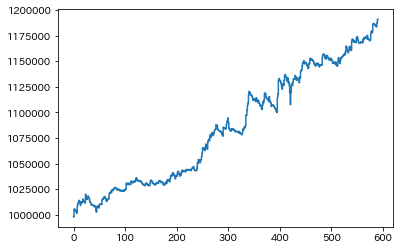

In [317]:
pos_df = pd.read_csv('Instrument_pos_df/{:0>8}.csv'.format(75309))
plt.plot(pos_df['assets'], ds='steps')
plt.show()

In [305]:
inst_df[inst_df['instrument']=='GBP_JPY'].sort_values(by='profit', ascending=False).head(20)

,instrument,K,gran,ref,pos_count,profit,WP(%),POR,PF,E(円),DD(%),KLY(%)
75453,GBP_JPY,1.0,H8,8,1006,226.014,42.94,1.9535,1.4702,224.666,1.39,13.73
75480,GBP_JPY,1.4,H8,7,481,212.696,46.15,1.9364,1.6598,442.195,2.12,18.35
75459,GBP_JPY,1.1,H8,7,838,210.550,43.44,1.9228,1.4766,251.253,1.92,14.02
75473,GBP_JPY,1.3,H8,7,586,203.198,43.52,2.0168,1.5537,346.754,1.66,15.51
75466,GBP_JPY,1.2,H8,7,700,202.452,44.00,1.9177,1.5067,289.217,1.68,14.80
75452,GBP_JPY,1.0,H8,7,1060,201.786,42.08,1.9383,1.4080,190.364,1.56,12.19
75465,GBP_JPY,1.2,H8,6,694,200.038,42.65,2.0056,1.4916,288.239,1.63,14.06
75460,GBP_JPY,1.1,H8,8,834,199.816,43.88,1.8458,1.4435,239.588,1.84,13.48
75472,GBP_JPY,1.3,H8,6,590,196.404,43.05,2.0025,1.5138,332.888,2.15,14.61
75481,GBP_JPY,1.4,H8,8,467,192.652,44.97,1.9642,1.6050,412.531,1.85,16.95


In [312]:
# df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', 'H12', 'GBP_JPY')
pos_df = back_test(df, 'GBP_JPY', fee=0.014, seed_money=1000000, K=1.1, ref=4, kly_rate=0.5, print_=False)

In [308]:
inst = 'GBP_JPY'
pip_spread(inst, print_=True), sp[inst]

0.01JPY = 1pips, spread: 1.4pips, 0.013999999999999999JPY


(None, 0.014)

In [313]:
get_evaluation(pos_df)

勝率: 44.67%
ペイオフレシオ: 1.8762
プロフィットファクター: 1.5180
期待値: 1544.267円
最大ドローダウン: 149484.7円, 9.47%
ケリー基準: 15.18%


In [314]:
pos_df.tail(1)

,lot,l_or_s,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
590,6640,short,2019-12-13 10:00:00+00:00,145.808,2019-12-25 22:00:00+00:00,142.219,357.5,23738.0,1912661.551


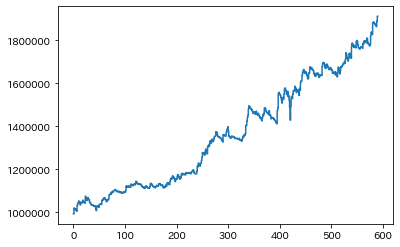

In [315]:
plt.plot(pos_df['assets'], ds='steps')
plt.show()

In [ ]:
# DD修正
for i in range(len(inst_df)):
    pos_df = pd.read_csv('Instrument_pos_df/{:0>8}.csv'.format(i))
    WP, POR, PF, E, DD, KLY = get_evaluation(pos_df, return_=True)
    inst_df.iat[i, 10] = DD

In [318]:
inst_df[inst_df['instrument']=='EUR_JPY'].sort_values(by='profit', ascending=False).head(20)

,instrument,K,gran,ref,pos_count,profit,WP(%),POR,PF,E(円),DD(%),KLY(%)
8919,EUR_JPY,1.9,H3,3,836,171.569,46.41,1.7909,1.5510,205.226,2.47,16.49
8926,EUR_JPY,2.0,H3,3,746,153.597,45.31,1.8215,1.5090,205.894,2.66,15.28
8913,EUR_JPY,1.8,H3,4,891,149.149,44.44,1.7829,1.4263,167.395,3.33,13.28
8912,EUR_JPY,1.8,H3,3,958,140.501,45.51,1.6618,1.3880,146.661,3.61,12.72
8921,EUR_JPY,1.9,H3,5,732,134.310,44.13,1.7933,1.4163,183.484,2.75,12.97
8928,EUR_JPY,2.0,H3,5,638,131.686,43.10,1.9172,1.4524,206.404,2.37,13.43
8899,EUR_JPY,1.6,H3,4,1209,127.654,42.02,1.7962,1.3017,105.586,2.53,9.74
8947,EUR_JPY,2.3,H3,3,532,126.493,44.36,1.8798,1.4988,237.769,1.95,14.76
8776,EUR_JPY,1.9,H4,7,440,124.836,44.32,1.9685,1.5668,283.718,2.70,16.03
8238,EUR_JPY,0.5,H12,8,1964,123.805,41.96,1.6942,1.2246,63.037,1.14,7.69


In [322]:
inst_df.shape

(97609, 12)

### df + pos_df

In [94]:
df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', 'H12', 'GBP_JPY')

In [98]:
df.head(50)

,Time,Volume,Open,High,Low,Close
0,2009-12-31 22:00:00+00:00,5,150.345,150.373,150.337,150.373
1,2010-01-03 10:00:00+00:00,1032,150.358,150.361,149.769,149.814
2,2010-01-03 22:00:00+00:00,46714,149.810,150.458,149.087,150.391
3,2010-01-04 10:00:00+00:00,47832,150.387,150.721,148.663,148.793
4,2010-01-04 22:00:00+00:00,47987,148.791,149.158,147.360,147.486
5,2010-01-05 10:00:00+00:00,55048,147.484,147.572,146.146,146.652
6,2010-01-05 22:00:00+00:00,48185,146.654,148.130,146.004,147.956
7,2010-01-06 10:00:00+00:00,54658,147.958,148.462,147.056,147.881
8,2010-01-06 22:00:00+00:00,46722,147.879,148.298,147.068,147.997
9,2010-01-07 10:00:00+00:00,56251,147.995,148.774,147.796,148.750


In [97]:
pos_df.head()

,lot,l_or_s,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
0,1000,short,2010-01-05 10:00:00+00:00,146.654,2010-01-12 22:00:00+00:00,148.494,-185.4,-1854.0,998146.0
1,1000,long,2010-01-12 22:00:00+00:00,148.494,2010-01-19 22:00:00+00:00,148.288,-22.0,-220.0,997926.0
2,1000,short,2010-01-19 22:00:00+00:00,148.288,2010-02-04 22:00:00+00:00,140.493,778.1,7781.0,1005707.0
3,1000,long,2010-02-04 22:00:00+00:00,140.493,2010-02-05 10:00:00+00:00,139.783,-72.4,-724.0,1004983.0
4,1000,short,2010-02-05 10:00:00+00:00,139.783,2010-02-09 10:00:00+00:00,140.987,-121.8,-1218.0,1003765.0


In [ ]:
# バックテスト
def back_test(df, inst, fee, seed_money, K, ref=5, lot=1000, kly_rate='None', print_=True):
    range_ = 0
    range_list = []
    ave_range = 0
    least_5 = 0
    pos = 'None'
    assets = seed_money
    tmp_i = 0
    lot_l = []
    l_or_s = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []

    # 実行
    for i in range(len(df) - 1):
        rate = df.iat[i, 5] # 当日の終値
        next_rate = df.iat[i+1, 2] # シグナル点灯した次の足の始値
        range_ = round(df.iat[i, 3] - df.iat[i, 4], 3) # High - Low
        range_list.append(range_)
    
        if i > ref:
            least_m = round(mean(range_list[i-ref-1:i-1]) * K, 3)
            open_high = round(df.iat[i, 3] - df.iat[i, 2], 3) # High - Open
            open_low = round(df.iat[i, 2] - df.iat[i, 4], 3) # Open - Low

            # 上昇トレンドと判断しロング
            if least_m < open_high and open_low < open_high:
                if pos == 'entry_long':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_short':
                        exit_rate = next_rate
                        pips = (entry_rate - exit_rate - fee) * 100
                        if kly_rate != 'None':
                            kly = assets * kly_rate
                            lot = math.floor(kly / exit_rate)
                        profit = pips * lot / 100
                        assets = round(assets + profit, 4)
                        lot_l.extend([lot])
                        l_or_s.extend(['short'])
                        entry_date.extend([df.iat[tmp_i, 0]])
                        entry_rate_l.extend([entry_rate])
                        exit_date.extend([df.iat[i, 0]])
                        exit_rate_l.extend([exit_rate])
                        pips_l.extend([pips])
                        profit_l.extend([profit])
                        assets_l.extend([assets])
                        if assets < 0:
                            break
                    entry_rate = next_rate
                    pos = 'entry_long'
                    tmp_i = i
        
            # 下降トレンドと判断しショート
            if least_m < open_low and open_high < open_low:
                if pos == 'entry_short':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_long':
                        exit_rate = next_rate
                        pips = (exit_rate - entry_rate - fee) * 100
                        if kly_rate != 'None':
                            kly = assets * kly_rate
                            lot = math.floor(kly / exit_rate)
                        profit = pips * lot / 100
                        assets = round(assets + profit, 4)
                        lot_l.extend([lot])
                        l_or_s.extend(['long'])
                        entry_date.extend([df.iat[tmp_i, 0]])
                        entry_rate_l.extend([entry_rate])
                        exit_date.extend([df.iat[i, 0]])
                        exit_rate_l.extend([exit_rate])
                        pips_l.extend([pips])
                        profit_l.extend([profit])
                        assets_l.extend([assets])
                        if assets < 0:
                            break
                    entry_rate = next_rate
                    pos = 'entry_short'
                    tmp_i = i
    
    pos_df = pd.DataFrame(data={'lot': lot_l, 'l_or_s': l_or_s, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df, df_pos_df

In [101]:
pos_df.head()

,lot,l_or_s,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
0,1000,short,2010-01-05 10:00:00+00:00,146.654,2010-01-12 22:00:00+00:00,148.494,-185.4,-1854.0,998146.0
1,1000,long,2010-01-12 22:00:00+00:00,148.494,2010-01-19 22:00:00+00:00,148.288,-22.0,-220.0,997926.0
2,1000,short,2010-01-19 22:00:00+00:00,148.288,2010-02-04 22:00:00+00:00,140.493,778.1,7781.0,1005707.0
3,1000,long,2010-02-04 22:00:00+00:00,140.493,2010-02-05 10:00:00+00:00,139.783,-72.4,-724.0,1004983.0
4,1000,short,2010-02-05 10:00:00+00:00,139.783,2010-02-09 10:00:00+00:00,140.987,-121.8,-1218.0,1003765.0
